# Hybrid Model Combination 

In [9]:
# Libraries to work with the data and plots
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# This file include the error metrics and the function for evaluating the weights for the forecast combination 
from error_metrics_weights import *

# This files include the implementation of the Forecast Models
from nn_2_models import *
from heuristic_models import *
from statisical_models import *

# This file include functions like preparation of data, evaluation of models and visualization of the predictions
from functions import *

In [10]:
# Importing the trained and tested values
df_train = pd.read_csv("Hourly_wdates.csv", index_col=0)
df_test = pd.read_csv("Hourly-test.csv", index_col=0)

# Time Series (For Hourly Between 1 and 414)
n = 25
# Numbers asked horizons
h = 48
# Data sets preparation
train, test = prepare_data(n,df_train,df_test)

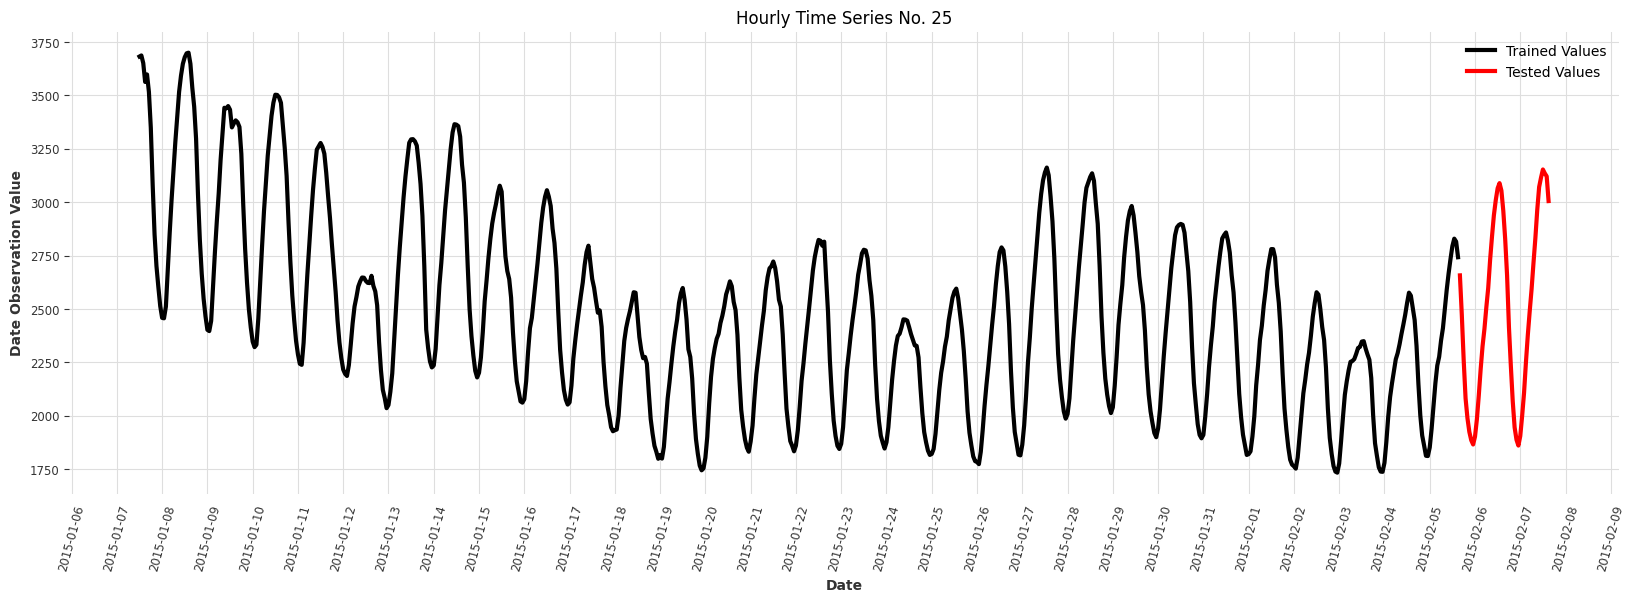

In [11]:
plot_original_data(train,test,n = n, h= h)

## Models 

### Heuristic Models (Faustino Vazquez)

#### - Triple Exponential Smoothing (Holt-Winters)

Triple Exponential Smoothing, also known as Holt-Winters method, is a powerful forecasting method that takes into account trend and seasonality. It uses three smoothing equations - one for the level, one for the trend, and one for the seasonal component. The equations are as follows:

$$
\begin{align*}
L_t &= \alpha (y_t / S_{t-m}) + (1 - \alpha) (L_{t-1} + T_{t-1}) \\
T_t &= \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} \\
S_t &= \gamma (y_t / (L_{t-1} + T_{t-1})) + (1 - \gamma) S_{t-m}
\end{align*}
$$

Where:
- $L_t$ is the level component at time $t$
- $T_t$ is the trend component at time $t$
- $S_t$ is the seasonal component at time $t$
- $y_t$ is the observed value at time $t$
- $m$ is the period of seasonality
- $\alpha$, $\beta$, and $\gamma$ are the smoothing parameters for the level, trend, and seasonal components, respectively.

#### - Seasonal Moving Average

The Seasonal Moving Average model is a simple forecasting method that uses the average of the most recent season's data points. It is useful for forecasting data with a clear seasonal pattern. The formula is as follows:

$$ \hat{y}_{t+1} = \frac{1}{m} \sum_{i=0}^{m-1} y_{t-i} $$

Where:
- $\hat{y}_{t+1}$ is the forecasted value at time $t+1$
- $y_{t-i}$ is the observed value at time $t-i$
- $m$ is the period of seasonality

#### - Seasonal Naive Method

The Seasonal Naive Method is a forecasting method that assumes the future seasonal component will be the same as the last observed seasonal component. It is useful for data with a strong and consistent seasonal pattern. The forecast for time $t+h$ is given by:

$$ \hat{y}_{t+h|t} = y_{t+h-m(k+1)} $$

Where:
- $\hat{y}_{t+h|t}$ is the forecasted value at time $t+h$ given the observed values up to time $t$
- $y_{t+h-m(k+1)}$ is the last observed value at the same seasonal position
- $m$ is the period of seasonality
- $k$ is the integer part of $(h-1)/m$


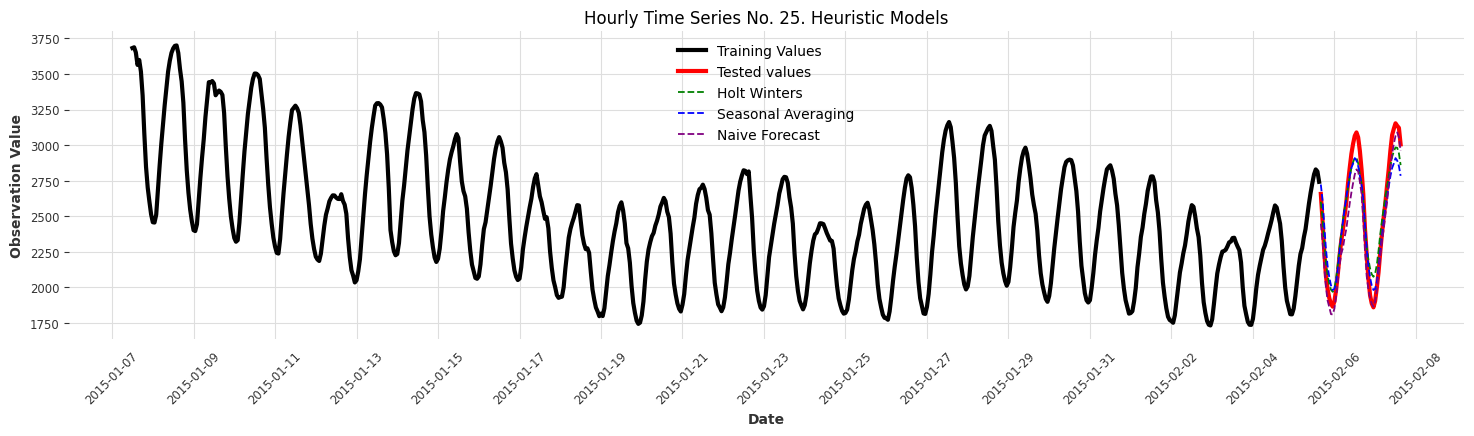

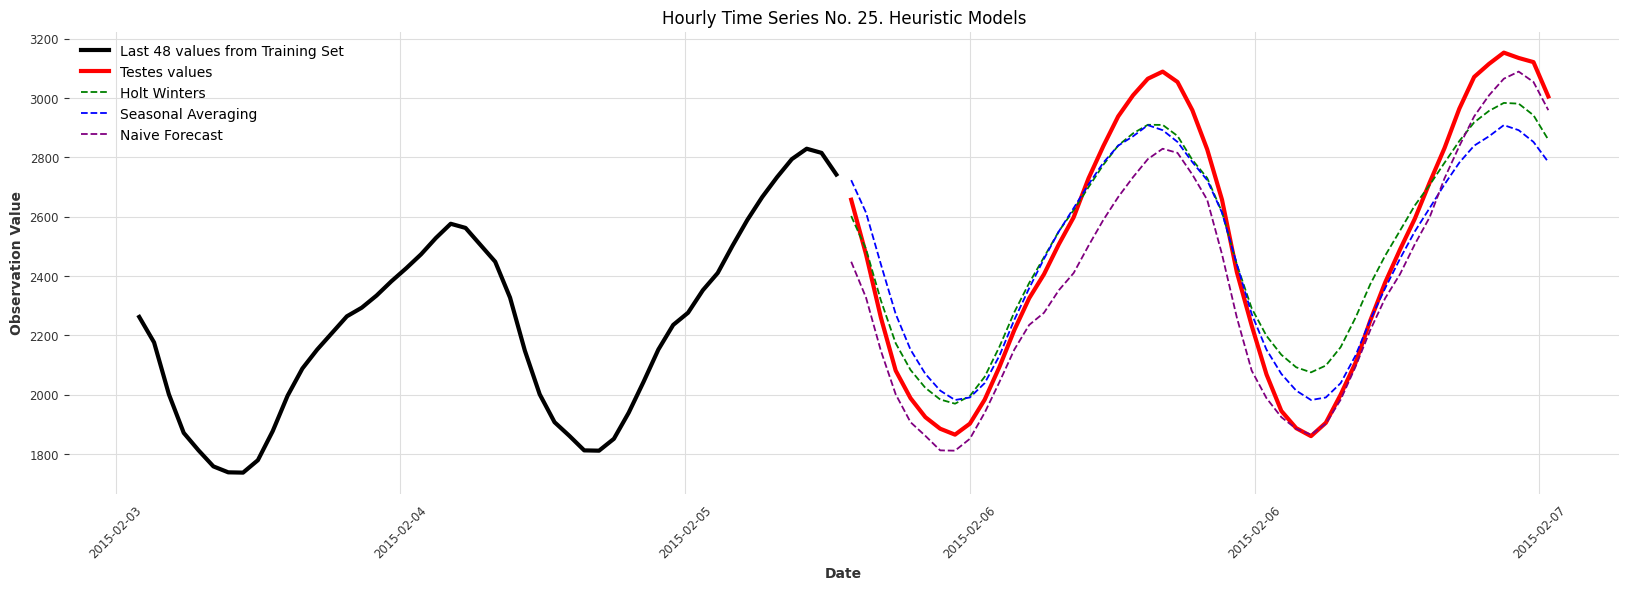

In [12]:
# Hyperparameters
alpha = 0.1
beta = 0.1
gamma = 0.1
seasonal_periods = 24  # Since we are working with Hourly data, the frequency is 24

holt_winters_forecast = holt_winters(train,test, alpha= alpha, beta= beta, gamma = gamma, seasonal_periods= seasonal_periods, horizons= h)
sea_average_forecast = seasonal_averaging_forecast(train,test[:h])
naive_forecast = seasonal_naive_forecast(train,test[:h],horizons=h)

plot_forecast(train, test, holt_winters_forecast,"Holt Winters", sea_average_forecast,"Seasonal Averaging", naive_forecast,"Naive Forecast", n,h,"Heuristic")

### Statistical Models (Alessandro Sapia)

#### - ARIMA AutoRegressive Integrated Moving Average) 
Characterized by three components: AutoRegression (AR), Integration (I), and Moving Average (MA). Typ-
ically denoted as ARIMA(p, d, q):

- AR(p): Autoregression model. A model that uses the dependent relationship between an observation and some number of lagged observations. The formula is:

$$ Y_t = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \epsilon_t $$

- I(d): Integrated. The use of differencing of raw observations to make the time series stationary. The formula is:

$$ Y'_t = Y_t - Y_{t-d} $$

- MA(q): Moving Average model. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. The formula is:

$$ Y_t = c + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} $$


#### - BATS (Box-Cox ARMA Time Series) 

Statistical model used for time series forecasting and analysis. Extension of the traditional ARIMA
model. BATS incorporates a Box-Cox transformation, which stabilizes the variance of
the time series data, useful when dealing with non-normal and heteroscedastic time
series data.

The Box-Cox transformation is given by:

$$ Y'_t = \frac{Y_t^\lambda - 1}{\lambda} $$

Where $\lambda$ is the transformation parameter. $\lambda=1$ is a log transformation, and $\lambda=0$ is a reciprocal square root transformation.
     
#### - SARIMAX 


SARIMAX is an extension of the ARIMA model that also includes a seasonal differencing term and allows for exogenous variables. The formula is:

$$ Y'_t = c + \sum_{i=1}^{p} \phi_i Y'_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{P} \Phi_i Y'_{t-mi} + \sum_{i=1}^{Q} \Theta_i \epsilon_{t-mi} + \epsilon_t $$

Where:
- $p$, $d$, and $q$ are the non-seasonal orders
- $P$, $D$, and $Q$ are the seasonal orders
- $m$ is the period of seasonality

In [13]:

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

arima_forecast = arima(train, test, horizons= h)
bats_forecast = bats(train, test, horizons= h)
sarimax_forecast = sarimax(train, test, horizons= h)

plot_forecast(train, test, arima_forecast,"ARIMA ", bats_forecast,"BATS", sarimax_forecast,"SARIMAX", n,h,"Statistical")

KeyboardInterrupt: 

### Neural Network Models (Elshan Dashtiyev)

#### - N-Beats

Uses deep learning to capture trends and seasonality. The model is made of multiple blocks, each designed
to understand different aspects of the time series. Through layers within these blocks, N-BEATS makes predictions by learning complex relationships in the data, enabling it to effectively forecast future values

#### - GRU

GRU is a type of recurrent neural network that is effective in processing sequences of data for tasks like time series prediction. It uses gating mechanisms to control and manage the flow of information between cells in the network. The GRU has two gates, a reset gate and an update gate. The reset gate determines how much of the previous state to keep, and the update gate determines how much of the new state is just a copy of the old one.

The mathematical formulation of a GRU is as follows:

$$ R_t = \sigma (X_t W_{xr} + H_{t-1} W_{hr} + b_r) $$
$$ Z_t = \sigma (X_t W_{xz} + H_{t-1} W_{hz} + b_z) $$
$$ H~_t = \tanh (X_t W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h) $$
$$ H_t = (1 - Z_t) \odot H_{t-1} + Z_t \odot H~_t $$

Where:
- $X_t$ is the input at time $t$
- $H_{t-1}$ is the hidden state of the previous time step
- $W_{xr}$, $W_{xz}$, $W_{hr}$, $W_{hz}$, $W_{xh}$, $W_{hh}$ are weight parameters
- $b_r$, $b_z$, $b_h$ are bias parameters
- $\sigma$ is the sigmoid function
- $\odot$ denotes element-wise multiplication



#### - LSTM (Long Short-Term Memory) 
Sspecialized in learning and remembering patterns over long sequences of data. They are good at capturing trends and seasonal patterns in time series data. 
LSTM models have memory cells and gates that control how information flows through the network, helping them to understand and predict complex patterns in the dataset


The mathematical formulation of an LSTM is as follows:

$$ f_t = \sigma_g(W_{f} x_t + U_{f} h_{t-1} + b_f) $$
$$ i_t = \sigma_g(W_{i} x_t + U_{i} h_{t-1} + b_i) $$
$$ o_t = \sigma_g(W_{o} x_t + U_{o} h_{t-1} + b_o) $$
$$ c_t = f_t \odot c_{t-1} + i_t \odot \sigma_c(W_{c} x_t + U_{c} h_{t-1} + b_c) $$
$$ h_t = o_t \odot \sigma_h(c_t) $$

Where:
- $x_t$ is the input at time $t$
- $h_{t-1}$ is the hidden state of the previous time step
- $c_{t-1}$ is the cell state of the previous time step
- $W_{f}$, $W_{i}$, $W_{o}$, $W_{c}$, $U_{f}$, $U_{i}$, $U_{o}$, $U_{c}$ are weight parameters
- $b_f$, $b_i$, $b_o$, $b_c$ are bias parameters
- $\sigma_g$, $\sigma_c$, $\sigma_h$ are activation functions (usually sigmoid for the gate activations and tanh for the others)
- $\odot$ denotes element-wise multiplication

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 4.9 M 
---------------------------------------------------
4.9 M     Trainable params
2.7 K     Non-trainable params
4.9 M     Total params
19.567    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - loss: 337.01 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 332.84 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 320.40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 305.7498 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 289.589 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 276.5828
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 73.641 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63.340 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 51.520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.86 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.70 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34.8448
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7603 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.529 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.356 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.248 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1794
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━

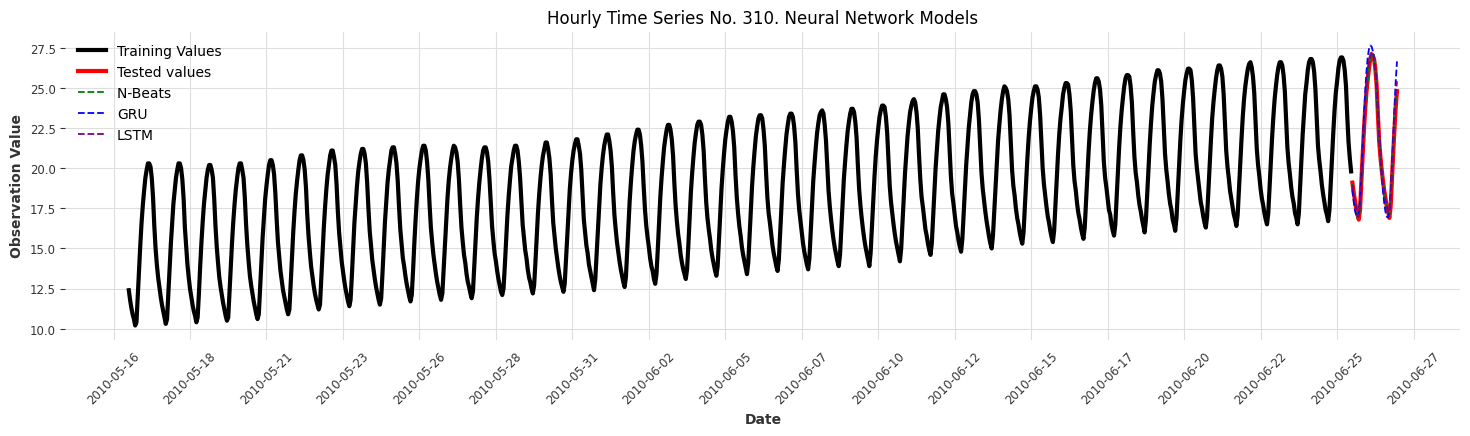

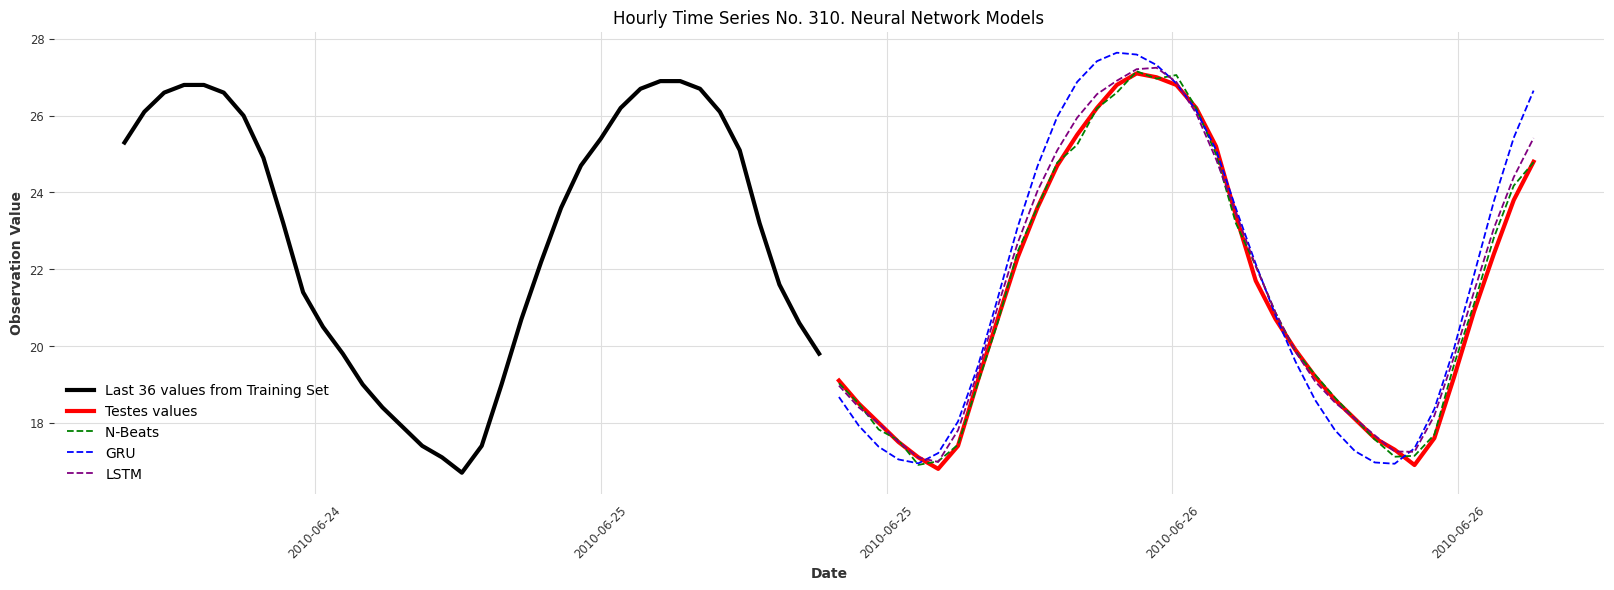

In [ ]:
from nn_2_models import *

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

n_beats_forecast = nbeats_model(train, test, horizons= h)
gru_forecast = gru_model(train, test, horizons= h)
lstm_forecast = lstm_model(train, test, horizons= h)

plot_forecast(train, test, n_beats_forecast,"N-Beats ", gru_forecast,"GRU", lstm_forecast,"LSTM", n,h,"Neural Network")

## Error Metrics

### Symmetric Mean Absolute Percentage Error (sMAPE)

The function calculates the Symmetric Mean Absolute Percentage Error (sMAPE), which is a measure of accuracy in a fitted time series model. The formula for sMAPE is:

$$ \text{sMAPE} = \frac{100\%}{n} \sum_{t=1}^{n} 2 \frac{|Y_t-\hat{Y_t}|}{|Y_t|+|\hat{Y_t}|} $$

Where:
- $Y_t$ is the actual value at time $t$
- $\hat{Y_t}$ is the predicted value at time $t$
- $n$ is the number of data points


### Mean Absolute Scaled Error (MASE)

The function calculates the Mean Absolute Scaled Error (MASE), another measure of accuracy in a fitted time series model. The formula for MASE is:

$$ \text{MASE} = \frac{\text{mean absolute error of the model}}{\text{mean absolute error of the naive forecast}} $$

Where:
- The mean absolute error of the model is the average absolute difference between the actual and predicted values
- The mean absolute error of the naive forecast is the average absolute difference between the actual values and the naive forecast (which is simply the previous value in the time series)



## Forecast Combination All models
### Equal Weight Forecast Combination

In the equal weight forecast combination, each of the $n$ forecasts is assigned the same weight, regardless of their individual error metrics. 

The weight $w_i$ assigned to the $i$-th forecast is calculated as:

$$
w_i = \frac{1}{n}
$$

Since each forecast is given the same weight, the weights naturally sum to 1:

$$
\sum_{i=1}^{n} w_i = 1


In [ ]:
forecasts = {
    'N-BEATS': n_beats_forecast,
    'GRU': gru_forecast,
    'LSTM': lstm_forecast,
    'ARIMA': arima_forecast,
    'BATS': bats_forecast,
    'SARIMAX': sarimax_forecast,
    'Holt-Winters': holt_winters_forecast,
    'Seasonal Average': sea_average_forecast,
    'Naive': sea_average_forecast
}

evaluate_and_plot_forecasts_9(train, test[:h], forecasts, h, n, type = "All Models")

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Model            ┃   sMAPE (%) ┃   MASE ┃ Weight   ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ N-BEATS          ┃        0.65 ┃   0.78 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ GRU              ┃        3.07 ┃   3.77 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ LSTM             ┃        1.18 ┃   1.46 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ ARIMA            ┃        2.75 ┃   3.22 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ BATS             ┃        0.17 ┃   0.2  ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ SARIMAX          ┃        0.16 ┃   0.19 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Holt-Winters     ┃        0.61 ┃   0.68 ┃ 0.11     ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Seasonal Average ┃       18.83 ┃  20.44 ┃ 0.11     ┃
┣━━━━━━━━━

## Forecast Combination Best Three models
### Estimate Inverse ErrorWeights

Given a set of $n$ forecasts, each with an error metric $e_i$, the weight $w_i$ assigned to the $i$-th forecast is calculated as the inverse of the average normalized error:

$$
w_i = \frac{1}{\frac{1}{n} \sum_{j=1}^{n} \frac{e_{ij}}{\max_{k} e_{kj}}}
$$

Where:
- $e_{ij}$ is the $j$-th error metric of the $i$-th forecast.
- $\max_{k} e_{kj}$ is the maximum value of the $j$-th error metric across all forecasts.

These weights are then normalized so they sum to 1:

$$
w_i = \frac{w_i}{\sum_{j=1}^{n} w_j}
$$

This results in forecasts with lower average normalized error (more accurate) receiving higher weight. The normalization of the error metrics ensures that they contribute equally to the final weights despite their different scales and interpretations.

In [ ]:
forecasts_heuristic = {
    'Triple Exponential Smoothing': holt_winters_forecast,
    'Seasonal Moving Average': sea_average_forecast,
    'Seasonal Naive Method': sea_average_forecast
}

forecasts_statistical = {
    'ARIMA': arima_forecast,
    'BATS': bats_forecast,
    'SARIMAX': sarimax_forecast
}

forecasts_nn = {
    'N-Beats': n_beats_forecast,
    'GRU': gru_forecast,
    'LSTM': lstm_forecast
}

evaluate_and_plot_forecasts_3(train, test[:h],h, forecasts_heuristic, forecasts_statistical, forecasts_nn)


┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Model Category        ┃ Best Model                   ┃   sMAPE (%) ┃   MASE ┃ Weight   ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Heuristic Models      ┃ Triple Exponential Smoothing ┃        0.61 ┃   0.68 ┃ 0.179    ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Statistical Models    ┃ SARIMAX                      ┃        0.16 ┃   0.19 ┃ 0.66     ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Neural Network Models ┃ N-Beats                      ┃        0.65 ┃   0.78 ┃ 0.162    ┃
┣━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━┫
┃ Combined Model        ┃ Combined Forecast            ┃        0.24 ┃   0.29 ┃ N/A      ┃
┗━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━┻━━━━━━━━━━┛